# Analysis of soil microbial traits and carbon cycling

### Overview and goals

This R script gives an outline some of the analyses used for the paper “A genomic perspective on stoichiometric
regulation of soil carbon cycling” by Hartman et al. 2017 The ISME Journal (11) 2652–2665. Soil carbon (C) cycling, nutrients and microbes were compared across a series of rice fields spanning much of the global range in soil C. This analysis show that soil C cycling is linked to the availability of carbon (C), nitrogen (N), and phosphorus (P).

Ecosystem scale element coupling arises from underlying tradeoffs in C, N, and P use in microbial genomes.
I use three data sets with observations per soil: chemistry, genes, and microbes. The fourth data set is (later) key for this analysis: genes by microbes. This allows assessment of how shifts in ecosystem function reflects different
combinations of genes in microbes, related to their evolutionary history.

This notebook shows R code used to analyze microbial genes related to soil carbon cycling, and similar code was used to produce Figure 2 in the 2017 manuscript. 

### Outline:

#### 1) Soil chemistry and C cycling  
    -- not shown here

#### 2) Soil genes and C cycling -- Which genes are most closely related to soil C turnover?
    a) Get C, N, P cycling gene abundances and determine which are correlated with C turnover (as list)
    b) Organize these genes by function and get their abundance in soil
    c) Display color legends for gene categories and soils (heatmap row and columns)
    d) Plot heatmap of correlated gene abundances, by function and soils 
    e) Plot abundance of aggregated gene categories for C, N, and P as function of soil N:P ratios 
 
#### 3) Microbial traits linked to C cycling 
    -- not shown here

### Import required packages:

In [1]:
library(RColorBrewer)
library(gplots)
library(ggplot2)
library(gridExtra)
suppressMessages(library(Hmisc))


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



### Import datasets

In [2]:
soil.chem <- read.table("Soils.txt", header=TRUE, sep="\t")                                 # soil chemical variables
soil.genes <- read.table("Soil_genes.txt", header=TRUE, sep="\t")                           # soil gene counts
CNP.gene.hier <- read.table("CNP_genes.txt", header=TRUE, sep="\t")                         # gene hierarchy (ontology)

# 2): Soil genes and C cycling
### Which genes are most closely related to soil C turnover?


### a) Get C, N, P cycling genes and determine which are correlated

In [3]:
# Select only genes used for C, N, and P cycling
CNP.genes <-data.frame("Gene"=CNP.gene.hier$Gene)                                          # Get list of genes 
CNP.gene.abund <- merge(CNP.genes, soil.genes, by="Gene", all.x=TRUE)                      # merge to get Abundances of only CNP genes
  row.names(CNP.gene.abund)<-CNP.gene.abund$Gene                                           # set rownames before transpose

# Append soil C turnover data to gene abundance to test which genes are correlated
C.turn <- soil.chem$C_turnover                                                             # get C turnover / soil
CNP.gene.C.turn <- cbind(C.turn, t(CNP.gene.abund[,-1]))                                   # combine w./ transposed gene abund, drop gene column

Make correlation matrix and retain correlated genes 

In [4]:
# Get correlation square matrix for r and P values, only use first row
CNP.gene.corr.M <- rcorr(CNP.gene.C.turn)                                                  # test correlations
CNP.gene.corr.m <- data.frame("r"=CNP.gene.corr.M$r[-1,1], "P"=CNP.gene.corr.M$P[-1,1])    # combine r and P
CNP.gene.corr.m$P.fdr <- p.adjust(CNP.gene.corr.m$P, method="BH")                          # correct for false discovery rate

# Filter to make list of genes correlated to C turnover (r > 0.5, P.adj < 0.05)
p_cut = 0.05                                                                               # set p-value cutoff
r_cut = 0.5                                                                                # set corr. (r) cutoff
CNP.gene.corr.Pfilt <- subset(CNP.gene.corr.m, P.fdr < p_cut)                              # get genes < p_cut
CNP.gene.corr.P.r.filt <- subset(CNP.gene.corr.Pfilt, abs(r) > r_cut)                      # get genes > r_cut 
CNP.gene.corr.list <- data.frame("Gene"= row.names(CNP.gene.corr.P.r.filt))                # get list of corr. genes

### b) Organize these genes by function and get their abundance in soil

In [5]:
# Gather class/category info for each correlated gene
Gene.corr.hier<-merge(CNP.gene.corr.list,CNP.gene.hier, by="Gene", all.x=TRUE)             # merge corr. list w gene hier. 

# Add soil abundance data, order on gene index
Gene.corr.hier.abund <-merge(Gene.corr.hier,CNP.gene.abund, by="Gene", all.x=TRUE)         # merge
  Gene.corr.hier.abund<-Gene.corr.hier.abund[order(Gene.corr.hier.abund$Index),]           # sort

### get gene count data only
Gene.abund <- Gene.corr.hier.abund[,(1+ncol(Gene.corr.hier)):ncol(Gene.corr.hier.abund)]   # ignore 1st ncol in corr.hier
  row.names(Gene.abund)<-Gene.corr.hier.abund$Gene                                         # make genes rownames, before transform

Then normalize relative abundance of genes across sites (z-scores) and gather gene and class data for interpretation 

In [6]:
# transpose first so normalized by relative abundance in each soil, transpose back
Gene.abundZ<-scale(t(log(Gene.abund)), center=TRUE, scale=TRUE)                            # LOG counts before scale to norm. distrib.
Gene.abundZ<-data.matrix(t(Gene.abundZ))                                                   # transpose again to rotate fig
row.names(Gene.abundZ) <-Gene.corr.hier.abund$Gene_name                                    # Replace gene ID with ID + short names
# row.names(Gene.abundZ) <-Gene.corr.hier.abund$Gene_fxn                                   # or full fxn names

# Get colors for labeling soil C, gene class and categories
Gene.class.color<-as.vector(unlist(Gene.corr.hier.abund$Class_color))                      # class colors 
Gene.category.color<-as.vector(unlist(Gene.corr.hier.abund$Category_color))                # category colors 
Field.C.color<-as.vector(unlist(soil.chem$Field_C_color))                                  # field colors

### c) Display color legends for gene categories and soils (heatmap row and columns)

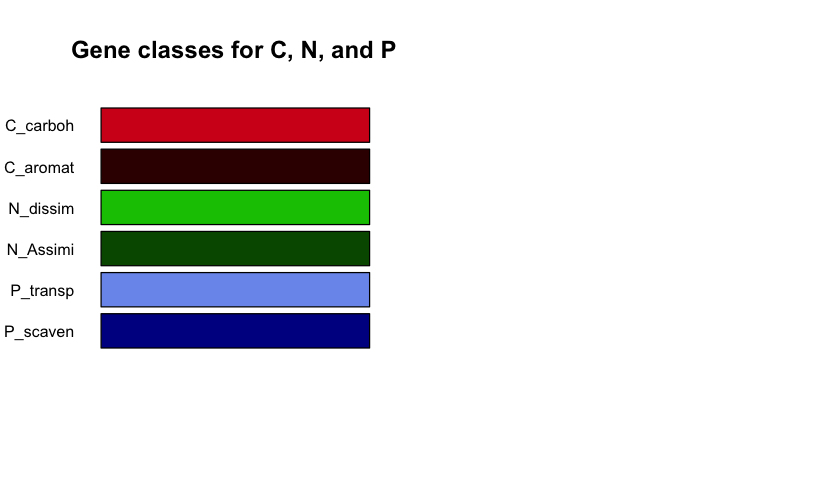

In [7]:
par(mfrow=c(1,2))

# Make color legends for functional groups of genes
  Gene.class.levels <- as.character(substr(unique(Gene.corr.hier.abund$Class),1,8))       # get gene classes    
  Gene.class.counts <- c(rep(1,length(Gene.class.levels)))                                # count gene classes
  Gene.class.colors <- as.character(unique(Gene.corr.hier.abund$Class_color))             # get gene colors
barplot(Gene.class.counts, col=rev(Gene.class.colors), names.arg=rev(Gene.class.levels),  # Make rotated barplot
        axes=FALSE, las=2, cex.names=0.8, horiz=TRUE, main="Gene classes for C, N, and P")
options(repr.plot.width=7, repr.plot.height=4)

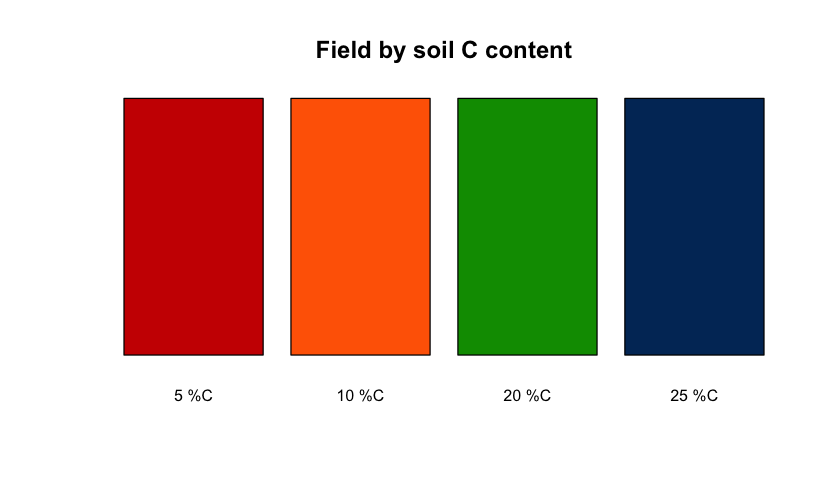

In [8]:
# Make color legends for soils 
  Soil.levels <-as.character(unique(soil.chem$Field_C))                                  # Get list of fields
  Soil.counts <- c(rep(1,length(Soil.levels)))                                           # Count field levels
  Soil.colors <- as.character(unique(soil.chem$Field_C_color))                           # Get field colors

barplot(Soil.counts, col=Soil.colors, names.arg=Soil.levels, axes=FALSE,                 # make barplot
        main = "Field by soil C content",cex.names=0.8)
options(repr.plot.width=4, repr.plot.height=2)
par(mfrow=c(1,1)) # return graphics state to original config

### d) Plot heatmap of correlated genes by function and soils 

Warning message in heatmap.2(Gene.abundZ, Rowv = F, Colv = F, RowSideColors = Gene.class.color, :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”Warning message in heatmap.2(Gene.abundZ, Rowv = F, Colv = F, RowSideColors = Gene.class.color, :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”

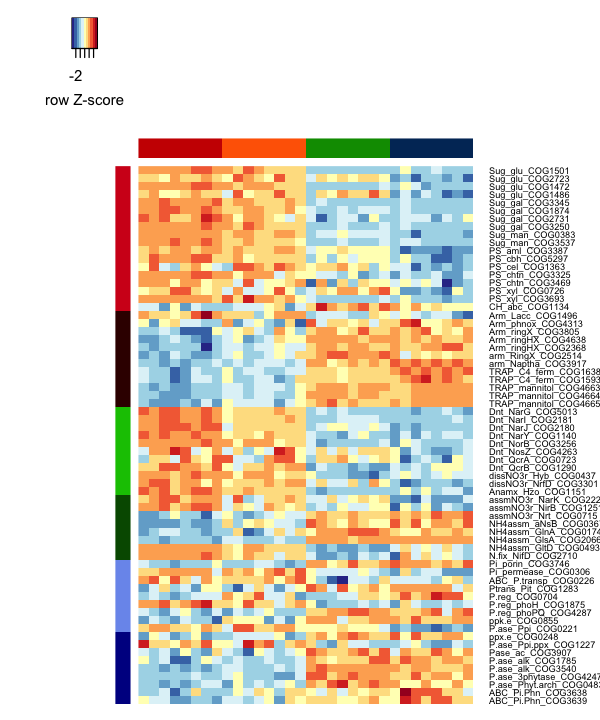

In [9]:
options(repr.plot.width=5, repr.plot.height=6)
heatmap.2(Gene.abundZ, Rowv=F, Colv=F, RowSideColors=Gene.class.color,
          ColSideColors=Field.C.color, col = rev(brewer.pal(11,"RdYlBu")),
          trace="none", key=TRUE, density.info="none",
          keysize=1, key.title = NA, key.xlab="row Z-score", 
          margins = c(1, 8), cexRow=0.7, cexCol=0.5)

In order to see how well the data groups itself by gene categories and soil types, I did not using typical hierarchical clustering of genes or sites here. The groupings by category are already pretty good!  

### e) Abundance of aggregated gene categories for C, N, and P vary with soil N:P ratios 

Since these groupings look so nice in the heatmap, why not plot them together as a group?

In [10]:
Class<-Gene.corr.hier.abund$Class
Aggr.CNP.fxns <- aggregate(Gene.abund, by=list(Class), FUN=sum)                        # aggregate 
  row.names(Aggr.CNP.fxns) <-Aggr.CNP.fxns[,1]                                         # add row.names before t
Agg.CNP.fxns<-t(Aggr.CNP.fxns[,-1])                                                    # transpose

# combine with soil N:P ratio data
Soil.N_P <-data.frame("N_P"= soil.chem$N_P)                                            # get soil N:P
Agg.CNP.DS <-cbind(Soil.N_P, Agg.CNP.fxns)                                             # join data

Plot genes classes vs. soil N:P, showing Redfield ratio (N:P = 16:1)

### Make N:P ratio scatterplot function with smoothed fit

In [11]:
# make ggplot function -- note 
# need to use "aes_string", pass args as strings
# all x vars N:P here

NP_scatter = function(y_var, color, title) { 
# Carbon gene classes
    pp <-ggplot(Agg.CNP.DS, aes_string("N_P", y_var)) +
    geom_point(color=color) + scale_x_log10(breaks=c(12,16,20,30,50,70)) + 
    geom_smooth(method="auto", se=FALSE, fullrange=FALSE, color=color,linetype="solid") +
    geom_vline(xintercept=16, linetype="dashed") +
    labs(title=title, x="Soil N:P", y=y_var)
    #print(pp)
}

In [12]:
# Shorten gene class colors
Gcolrs = Gene.class.colors          #Gcolrs[1]

In [13]:
# Make N:P plots for each var  -- this could be looped using gene.class.levels, gene.class.colors
Ccp <- NP_scatter("C_carbohydrates", Gcolrs[1],"Carbon")     # Ccp
Cap <- NP_scatter("C_aromatics", Gcolrs[2],"")               # Cap

Ndp <- NP_scatter("N_dissimilation", Gcolrs[3],"Nitrogen")   # Ndp
Nap <- NP_scatter("N_Assimilation", Gcolrs[4],"")            # Nap

Ptp <- NP_scatter("P_transp_intnl", Gcolrs[5],"Phosphorus")  # Ptp
Psp <- NP_scatter("P_scavenging", Gcolrs[6],"")              # Psp

### Plot aggregated data together

`geom_smooth()` using method = 'loess'
`geom_smooth()` using method = 'loess'
`geom_smooth()` using method = 'loess'
`geom_smooth()` using method = 'loess'
`geom_smooth()` using method = 'loess'
`geom_smooth()` using method = 'loess'


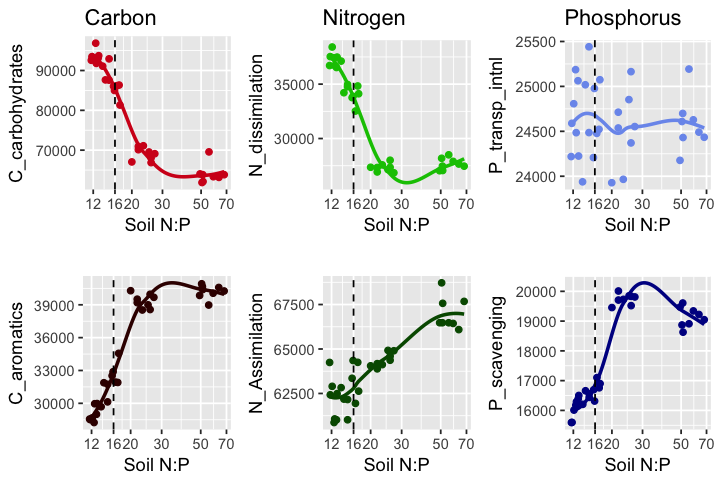

In [14]:
options(repr.plot.width=6, repr.plot.height=4)
grid.arrange(Ccp, Ndp, Ptp, Cap, Nap, Psp,ncol=3, nrow =2)

Microbes in lower % soil carbon (C) fields have greater potential carbohydrate utilization, while higher % C fields use more aromatic compounds.  Also, lower % C fields have more potential dissimilatory nitrogen N metabolism  (e.g denitrification), while higher % C fields have greater P scavenging, consistent with their higher N:P ratios.

n.b. I have used a less refined classification scheme for P uptake genes here, which accounts for differences in P uptake gene patterns compared to the manuscript.  Here P uptake genes include many regulators and internal cycling like polyphosphate kinase.  Note the noisiness of these genes in the heatmap.  Here the y values are counts per 10 M, not per 1M as in the paper.

Better regression fitting methods were used in the paper, comparing Box-Cox and polynomial regressions.